# Implementacion de metodos numericos con el oscilador armónico simple


## Oscilador armónico
El oscilador armónico es uno de los sistemas más estudiados en la física, ya que todo sistema que oscila al rededor de un punto de equilibrio estable se puede estudiar en primera aproximación como si fuera un oscilador.
La característica principal de un oscilador armónico es que está sometido a una fuerza recuperadora, que tiende a devolverlo al punto de equilibrio estable, con una intensidad proporcional a la separación respecto de dicho punto,

$$F = -k(x-x_0)$$

donde $k$ es la constante de recuperación, y $x_0$ es la posición de equilibrio, que sin pérdida de generalidad podemos tomar $ x_0 = 0$.

## Oscilador armónico simple

El oscilador armónico simple es el caso más sencillo, donde únicamente se considera la fuerza recuperadora. Teniendo en cuenta que $ F = m a = m \frac{\mathrm{d}^2 x}{\mathrm{d}t^2}$ , la ecuación $F = -k(x-x_0)$ nos da la siguiente ecuación diferencial

$$\frac{\mathrm{d}^2 x}{\mathrm{d}t^2} + \omega_0^2 x = 0 \ $$
donde los puntos indican derivación respecto del tiempo, y $ \omega_0^2 = \sqrt{k/m}$ es la frecuencia natural de vibración. La solución general a esta ecuación se puede escribir de la forma
)$$x(t) = A \sin \left( \omega_o t + \varphi_0 \right) \ $$


donde A y $ \varphi_0$ se obtienen imponiendo las condiciones iniciales

## Obtencion de datos

Para la implementacion de los metodos numericos apartir de la teoria dada se tuvo que implementar un experimento que tuviera una buena aproximacion de los modelos teoricos que vamos a analizar, se utlizo el siguiente mecanismo:

<center><img src="mecanismo.png" width="250" height="175"></center> 

Consta de una fuente de luz que proyecta ls sombra horizontal de una esfera sujeta a un disco que gira a una frecuencia constante por medio de un moto de 3v, la sombra se proyecta sobre un plano donde se han colocado 5 fotoresistencias(sensores de luz) equidistantes, dichos dispositivos mandaran una senal a un dispositivo arduino UNO que registrara dos listas, una de posicion y otra de tiempo. Los datos registrados por el dispositivo es posible tratarlo por la forma en la que se realizo una conexion entre arduino y python, un ejemplo de ello a continuacion:r

In [4]:
import serial
import time
import numpy as np

ser = serial.Serial('COM5', 9600, timeout=1)
time.sleep(2)

photoresistorDetections = []
detectionTimes = []

try:
    while True:
        if ser.in_waiting > 0:
            line = ser.readline().decode('utf-8').strip()
            if line == "Detecciones completadas:":
                ser.readline()
                for _ in range(50):
                    data_line = ser.readline().decode('utf-8').strip()
                    if data_line:
                        photoresistor, time_ms = data_line.split('\t\t')
                        photoresistorDetections.append(int(photoresistor))
                        detectionTimes.append(int(time_ms))
                break
finally:
    ser.close()

t = np.array(detectionTimes)
y_raw = np.array(photoresistorDetections)

SerialException: could not open port 'COM5': FileNotFoundError(2, 'The system cannot find the file specified.', None, 2)

Por falta de una mejor logistica y para mejorar la presentacion se usaran datos ya extraidos de una prueba con el mecanismo, la tanda de datos seleccionada es casi ideal, fue seleccionada entre unas pocas decenas de pruebas.

## Interpolacion

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import Bloque_1 as blo

t = np.array([0, 109, 218, 329, 438, 548, 657, 766, 875, 984])
y_raw = np.array([-2, -1,  0,  1,  2,  1,  0, -1, -2,])
y = y_raw

ytils = fft(y)

daty = [blo.fftinterp(ytils, i) for i in x]
plt.plot(t, y, 'ro', label='Datos')
plt.plot(t, daty, c='r', label='Interpolada')

plt.legend(frameon=False)

ValueError: operands could not be broadcast together with shapes (4,) (2,) 

## Fitting. Regresión No lineal de los Mínimos al cuadrado (Non-Linear Least-Squares Fitting)




El mejor ajuste es:  [-3090.31822064    11.09937627    18.03193268]
curve_fit:  [1.7124492  0.00720396 3.129149  ]


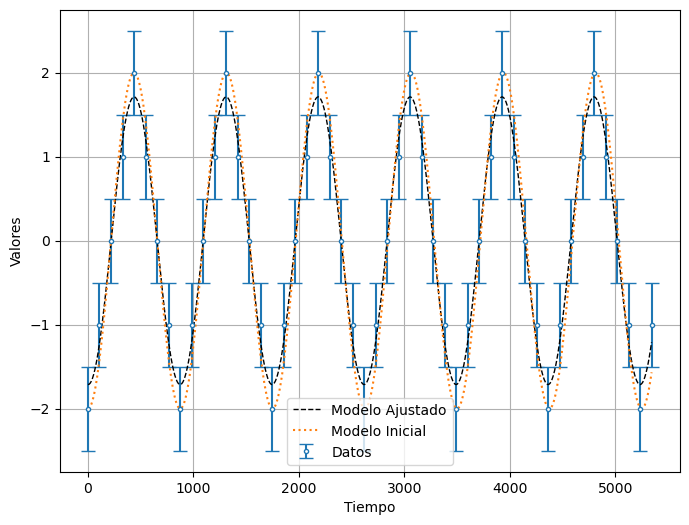

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import Bloque_1 as blo
from scipy.optimize import curve_fit

t = np.array([0, 109, 218, 329, 438, 548, 657, 766, 875, 984, 1093, 1202, 1311, 1420, 1529, 1638, 1747, 1856, 1965, 2074, 2183, 2292, 2401, 2510, 2619, 2728, 2837, 2946, 3055, 3164, 3273, 3382, 3491, 3600, 3709, 3818, 3927, 4036, 4145, 4254, 4363, 4472, 4581, 4690, 4799, 4908, 5017, 5126, 5235, 5344])
y_raw = np.array([-2, -1,  0,  1,  2,  1,  0, -1, -2, -1,  0,  1,  2,  1,  0, -1, -2,
       -1,  0,  1,  2,  1,  0, -1, -2, -1,  0,  1,  2,  1,  0, -1, -2, -1,
        0,  1,  2,  1,  0, -1, -2, -1,  0,  1,  2,  1,  0, -1, -2, -1])
y = y_raw

def gdata():
  data = np.zeros((3,50))
  data[0,:] = t
  data[1,:] = y
  data[2,:] = 0.5*np.ones(data.shape[1])
  
  return data

def model(cs, xi):
  p = cs[0]* np.cos(cs[1]*xi + cs[2]) 
  return p
def cos_model(t, A, omega, mu):
    return A * np.cos(omega * t + mu)
    
ckm1 = np.array([2, 0.00718, np.pi]) #2 * np.pi / np.mean(np.diff(t)), 0.00718, -np.pi/2
data = gdata()

ck = blo.gaussnewton(data, ckm1, tol=1.e-05)
print('El mejor ajuste es: ', ck)

params, params_covariance = curve_fit(cos_model, t, y, p0=ckm1)
print('curve_fit: ', params)

xval = np.linspace(data[0][0], data[0][-1], 500)

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.errorbar(data[0], data[1], yerr=data[2], capsize=5, ls='', marker='o', mfc='white', ms=3, mew=1, label='Datos')
#ax.plot(xval, model(ck, xval), ls='--', lw=1, c='k', label='Modelo Ajustado')
ax.plot(xval, model(params, xval), ls='--', lw=1, c='k', label='Modelo Ajustado')
ax.plot(xval, model(ckm1, xval), ls=':', label='Modelo Inicial')

ax.set_xlabel('Tiempo')
ax.set_ylabel('Valores')
ax.legend()
ax.grid(True)

https://www.lawebdefisica.com/dicc/oscil/